<a href="https://colab.research.google.com/github/barauna-lo/Colored_Noise/blob/main/CervejaGratis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# For the Next

* 27/10


1. Descartar o TraningLoop1

2. Alterar o Create data-set para escolher a fração de treinamento, teste e validação? (Isso mudaria os bachs?)

3. Criar dataframe de saída



* Implmentar uma LSTM Bidirecional para clasificação ???

### GNI = Gaussian Noise Input
----







# Scentific Questions

1 - Quantos pontos no espaço da frequencia fica em cada corte do PSD

2 - A normalização de $[0 1]$ tem impacto diferente de $[-1 1]$

3 - Qual é o melhor conjunto de pontos para realizar a predição do modelo?

3.1 -> 256 - 4096 (Extremo)

3.2 -> 512 - 4096 (Radical)

3. ->  512 - 2048

3.3 -> 1024 - 4096 (Aceitável)

3.4 -> 1024 - 2048 (Forçando um pouco)

3.5 -> 1024 - 1024 (Justo)




# Librarys

In [1]:
!pip install colorednoise
import colorednoise as cn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

import seaborn as sns
from matplotlib.gridspec import GridSpec
#np.random.seed(42)
sns.set_style('darkgrid')
%matplotlib inline
 
import warnings #https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
warnings.filterwarnings('default')#('ignore')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Functions

In [79]:
def create_dataset(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  '''
  This function will contain two vectors, dataX and dataY, the dataX will contain a set of numbers within the time series
  and the dataY will be its posterior value
  For example:
  list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  if the window_in is equal to 3 anf window_ou equato to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  dataX[3] = [3,4,5] ; dataY[3] = [6,7]
  strid will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
  dataset = dataset.reshape(len(dataset),1)
  dataset_train = dataset[:len(dataset)//2]
  dataset_test  = dataset[len(dataset)//2:]
  data_train_X, data_train_Y = [], []
  data_test_X, data_test_Y   = [], []

  for i in range(0,len(dataset_train)-window_in-window_ou+1,strid):
    data_train_X.append(dataset_train[i:(i+window_in), 0])
    data_train_Y.append(dataset_train[i + window_in:i + window_in + window_ou, 0])

    data_test_X.append(dataset_test[i:(i+window_in), 0])
    data_test_Y.append(dataset_test[i + window_in:i + window_in + window_ou, 0])
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float(),torch.tensor(np.array(data_test_X)).float(), torch.tensor(np.array(data_test_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)

def create_dataset2(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  '''
  NORMALIZED DATASET BETEWENN 0 AND 1
  This function will contain two vectors, dataX and dataY, the dataX will contain a set of numbers within the time series
  and the dataY will be its posterior value
  For example:
  list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  if the window_in is equal to 3 anf window_ou equato to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  dataX[3] = [3,4,5] ; dataY[3] = [6,7]
  strid will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
  # This function must 
  dataset = dataset.reshape(len(dataset),1)
  dataset_train = dataset[:len(dataset)//2]
  dataset_test  = dataset[len(dataset)//2:]
  data_train_X, data_train_Y = [], []
  data_test_X, data_test_Y   = [], []

  for i in range(0,len(dataset_train)-window_in-window_ou+1,strid):
    _,data_norm = norm2(dataset_train[i:i + window_in + window_ou])
    data_train_X.append(data_norm[0:(window_in)])
    data_train_Y.append(data_norm[ window_in:window_in + window_ou])
    #print(len(data_train_X[i]))

    _,data_norm = norm2(dataset_test[i:i + window_in + window_ou])
    data_test_X.append(data_norm[0:(window_in)])
    data_test_Y.append(data_norm[window_in:window_in + window_ou])
    #print((data_train_X).astype(float))
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float(),torch.tensor(np.array(data_test_X)).float(), torch.tensor(np.array(data_test_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)

def skew(t):
    """
    Computes the skewness of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`torchtorch.cross()`).
    :param t: a :class:`Tensor`
    :return: a scalar
    """
    return torch.mean(((t-torch.mean(t,dim=1)[:, None])/torch.std(t,dim=1)[:, None])**3,dim=1)

def kurtosis(t, fisher=True):
    """
    Computes the kurtosis of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`torchtorch.cross()`).
    :param t: a :class:`Tensor`
    :param fisher: if True (default) Fisher's definition is used, otherwise Pearson's (aka excess)
    :return: a scalar
    """
    return torch.mean(((t-torch.mean(t,dim=1)[:, None])/torch.std(t,dim=1)[:, None])**4,dim=1) - fisher*3    

def param(data):
  '''
  Print the Statiscal momentun from a givin dataset
  '''
  data = torch.tensor(data)
  output={'kurtosis':kurtosis(data),
          'mean':    torch.mean(data,dim=1),
          'skew':    skew(data),
          'std':     torch.std(data,dim=1)}
  return output    

def param_2(data):
  '''
  Print the Statiscal momentun from a givin dataset
  '''
  #data = torch.tensor(data)
  output={'kurtosis':kurtosis(data),
          'mean':    torch.mean(data,dim=1),
          'skew':    skew(data),
          'std':     torch.std(data,dim=1)}
  return output    

def norm(data):
  '''
  Normalize the dataframe from -1 to 1
  '''
  scaler = MaxAbsScaler()
  data1 = np.reshape(data,(-1, 1))
  data1 = scaler.fit_transform(data1)
  data2 = np.reshape(data1,len(data1))
  return data1, data2

# def norm2(data):
#   '''
#   Normaliza os dados entre 0 e 1
#   '''
#   scaler = MaxAbsScaler()
#   data1 = np.reshape(data,(-1, 1))
#   data1 = (scaler.fit_transform(data1)+1)/2 #Esta célula contem a diferença
#   data2 = np.reshape(data1,len(data1))
#   return data1, data2

def norm2(data):
  '''
  Normaliza os dados entre 0 e 1
  '''
  scaler = MinMaxScaler()
  data1 = np.reshape(data,(-1, 1))
  data1 = scaler.fit_transform(data1)
  data2 = np.reshape(data1,len(data1))
  return data1, data2  

def norm4(data):
  '''
  Normaliza os dados entre 0 e 1
  but return vectors in a single shape
  '''
  scaler = MinMaxScaler()
  data1 = np.reshape(data,(-1, 1))
  #data1 = data-np.min(data)
  #data1 = data1/np.max(data1)
  data1 = scaler.fit_transform(data1) #Esta célula contem a diferença
  data2 = np.reshape(data1,len(data1))
  return data2  

##################
# PLOT FUNCTIONS #
##################


def plot_psd(data,label='PSD',color='k'):
  ft = np.fft.fft(data)
  #ft = np.fft.fft(y[0,:])
  ft = np.real(ft*np.conj(ft))
  freq = np.fft.fftfreq(len(ft))
  seq = np.argsort(freq)
  a,b = np.polyfit(np.log(freq[freq>0.0]),np.log(ft[freq>0.0]),deg=1)
  text = "{} {}f + {}".format(label,np.round(a,3),np.round(b,3))
  #plota o psd
  return plt.loglog(freq[seq],ft[seq],color=color,label=text)  

def plot_test(x_,y_):
  empty = np.empty_like(x_)
  empty[:] = np.nan
  y2 = np.append(empty,y_)
  plt.plot(x_,label='Input')
  plt.plot(y2,label='Target')    

## Δβ - Diferent Index


A biblioteca pytorch possui as funções de transformada rápida de fourier (fft),respectivo conjunto de frequência (fftfreq) e logarítmo implementada já a nível vetorizado.

No entanto, foi necessário implementar manualmente o ajuste linear para medir o beta, uma boa referência (com o método dos minimos quadrados) é:

http://195.134.76.37/applets/AppletPoly/Appl_Poly2.html

In [30]:
# class DBeta(nn.Module):
#   def __init__(self):
#     super(DBeta, self).__init__();

#   def beta(self,vet):
#     ft = torch.fft.fft(vet,dim =1)
#     ft = ft*torch.conj(ft)
#     psd = torch.real(ft)
#     freq = torch.fft.fftfreq(vet.size(dim=1))
#     freq = freq.repeat(psd.size(dim=0),1)

#     # remove frequencias negativas e zero
#     freq = freq[:,1:vet.size(dim=1)//2]
#     psd = psd[:,1:vet.size(dim=1)//2]
#     #passa para escala log
#     freq = torch.log(freq)
#     psd = torch.log(psd)

#     # calcula o angulo do ajuste linear
#     b = (psd.size(dim=1)*torch.sum(psd*freq,dim=1)-torch.sum(psd,dim=1)*torch.sum(freq,dim=1))/(psd.size(dim=1)*torch.sum(freq**2,dim=1) - (torch.sum(freq,dim=1)**2) )
#     return b
    
#   def forward(self, predictions, target):
#     square_difference = torch.square(self.beta(predictions) - self.beta(target))
#     return torch.mean(square_difference)

#   def __call__(self, predictions, target):
#     square_difference = torch.square(self.beta(predictions) - self.beta(target))
#     return torch.mean(square_difference)

## Δβλ - Separete the PSD in `n_cut` sizes

In [156]:
class DBeta(nn.Module):
  def __init__(self,n_cut=1, low_freq_cut=0 ,high_freq_cut=0 ):
    super(DBeta, self).__init__();
    '''
    n_cut        - is the number of cuted betas
    low_freq_cut - Is the ignored first betas
    high_freq_cut - its the ignored last betas
    '''
    self.n_cut = n_cut
    self.high_freq_cut = high_freq_cut
    self.low_freq_cut = low_freq_cut
  def psd(self,vet):
      ft = torch.fft.fft(vet,dim =1)
      ft = ft*torch.conj(ft)
      psd = torch.real(ft)
      freq = torch.fft.fftfreq(vet.size(dim=1))
      freq = freq.repeat(psd.size(dim=0),1)
      freq = freq[:,1:vet.size(dim=1)//2]
      psd = psd[:,1:vet.size(dim=1)//2]
      return psd, freq

  
  
  def beta(self,vet): #n_cut number of cut for the series
    n_cut = self.n_cut
    low_freq_cut = self.low_freq_cut
    high_freq_cut = self.high_freq_cut
    psd,freq = self.psd(vet)
    beta= torch.zeros(vet.size(0), n_cut) 
    for i in range(low_freq_cut,n_cut-high_freq_cut):
      for j in range(vet.size(0)): 
        int_min,int_max = len(vet)**(-(i+1)/n_cut),len(vet)**(-(i)/n_cut)
        p = psd[j,:]
        f = freq[j,:]
        p = p[(f>int_min) & (f<int_max)]
        f = f[(f>int_min) & (f<int_max)]
        p = torch.log(p)
        f = torch.log(f)
        
        b = (p.size(0)*torch.sum(p*f)-torch.sum(p)*torch.sum(f))/(p.size(0)*torch.sum(f**2) - (torch.sum(f)**2) )
        beta[j,i] = b
    return beta
    
  def forward(self, predictions, target):
    square_difference = torch.square(self.beta(predictions) - self.beta(target))
    return torch.mean(square_difference)

  def __call__(self, predictions, target):
    square_difference = torch.square(self.beta(predictions) - self.beta(target))
    return torch.mean(square_difference)

# Data

## Data 1: - Simple $\sin(x)$ data 
https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7

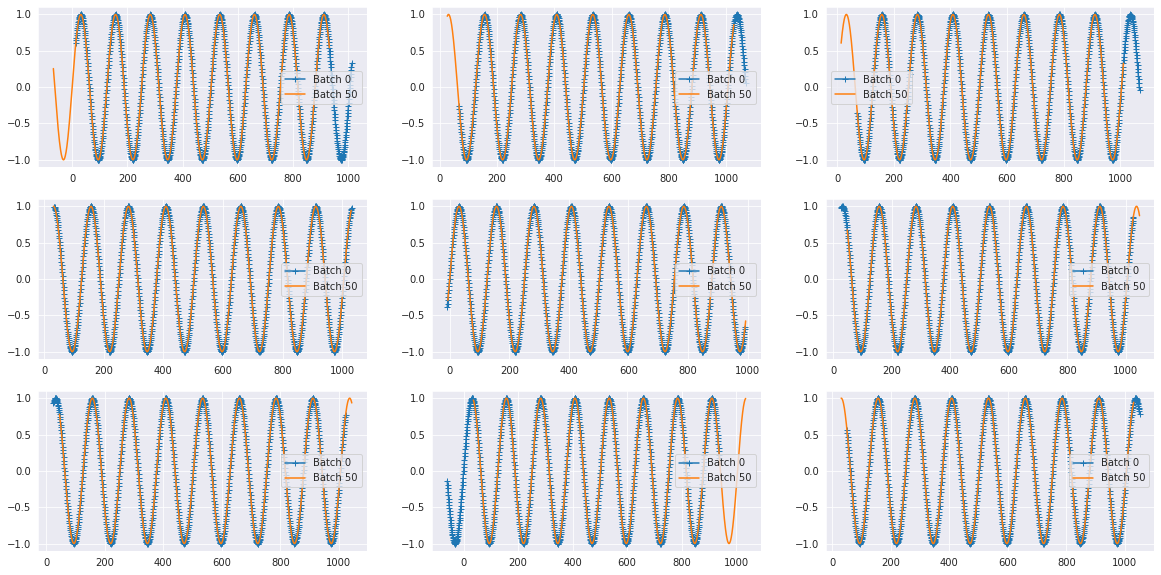

In [13]:
N = 100 # number of samples
L = 1000 # length of each sample (number of values for each sine wave)
T = 20 # width of the wave
x = np.empty((N,L), np.float32) # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
y = np.sin(x/1.0/T).astype(np.float32)

plt.figure(figsize=(20,10))
for k in range(9):
  plt.subplot(3,3,k+1)
  plt.plot(x[0+k],y[0+k], marker='+',label="Batch 0")
  plt.plot(x[50+k],y[50+k],label="Batch 50")
  plt.legend()
plt.show()

## Data 2: Combined $w_1 \sin(x) + w_2 \sin(x)$

Combined $w_1 \sin(x+\theta_1) + w_2 \sin(x+\theta_2) + Noise()$

https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb

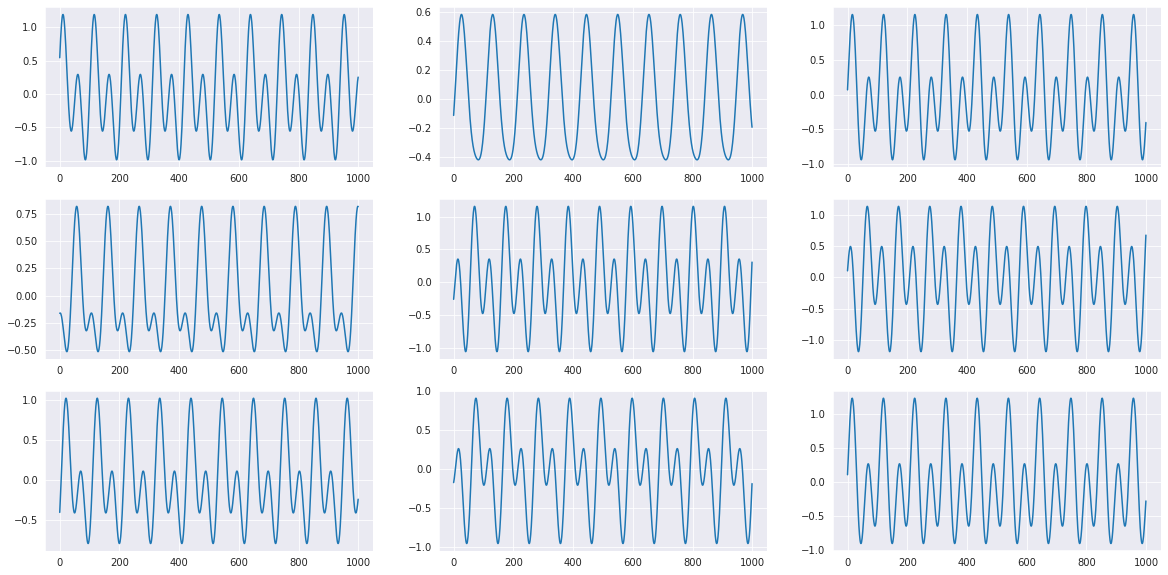

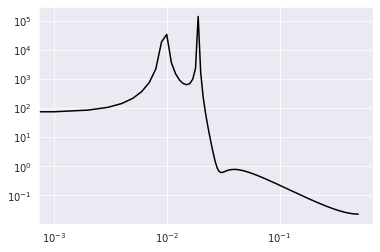

In [149]:
def generate_time_series(batch_size, n_steps,w1=0.5,w2=0,w3=0,var_freq=True):
    offsets1, offsets2 = np.random.rand(2, batch_size, 1)
    if var_freq == True:
      freq1, freq2 = np.random.rand(2, batch_size, 1)
    else:
      freq1, freq2 = np.empty((batch_size,n_steps), np.float32), np.empty((batch_size,n_steps), np.float32), 
      freq1[:], freq2[:] = 0.5,0.5
    time = np.linspace(0, 1, n_steps)
    series = w1 * np.sin((time - offsets1)  * (freq1 * 100 + 10))  #   wave 1
    series += w2 * np.sin((time - offsets2) * (freq2 * 200 + 20)) # + wave 2
    series += w2 * np.sin((time - offsets2+ offsets2) * (freq2 * 200 + 20)) # + wave 2
    series += w3 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series#[..., np.newaxis].astype(np.float32)

N = 100 # number of samples
L = 1000 # length of each sample (number of values for each sine wave)

y = generate_time_series(N,L,0.5,0.4,0.0000,var_freq=False)
plt.figure(figsize=(20,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.plot(y[i])
plt.show()
plot_psd(y[i])


## Data 3: Colored Noise

In [25]:
samples = 2**20

wn = cn.powerlaw_psd_gaussian(0, samples)
pn = cn.powerlaw_psd_gaussian(1, samples)
rn = cn.powerlaw_psd_gaussian(2, samples)

wn1,wn2 = norm2(wn)
pn1,pn2 = norm2(pn)
rn1,rn2 = norm2(rn)  

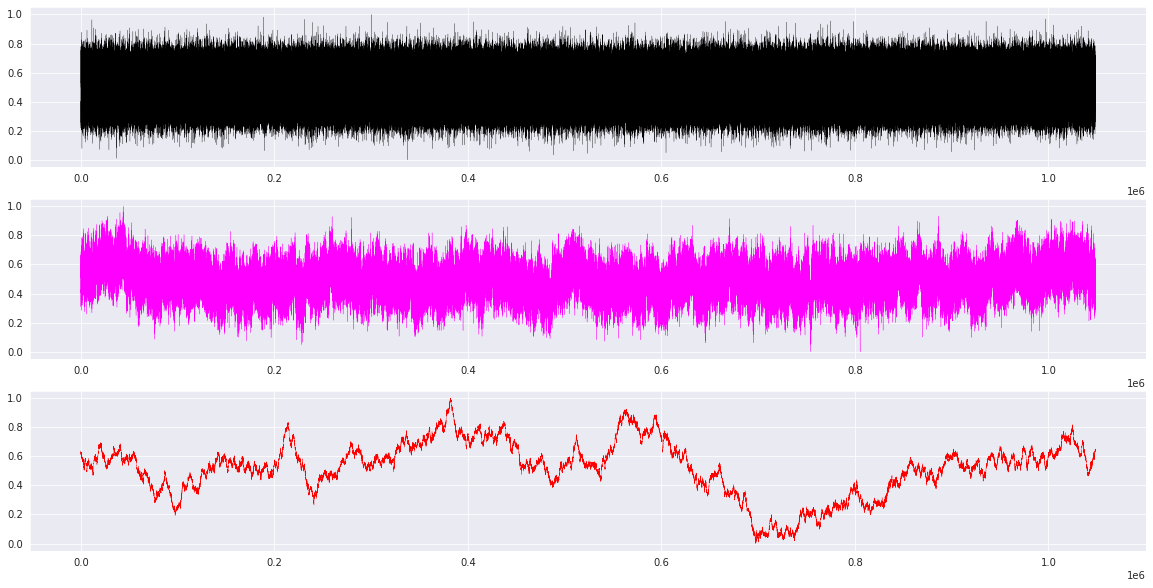

In [26]:
plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(wn2,color='black',alpha=1,linewidth=0.2)
plt.subplot(3,1,2)
plt.plot(pn2,color='magenta',alpha=1,linewidth=0.3)
plt.subplot(3,1,3)
plt.plot(rn2,color='red',linewidth=0.3)

plt.show()

# Creating `trainX` and `trainY`

In [85]:
1024//8

128

In [137]:
win_in = 1024
win_ou = 1024
jump = 512*8

dataset = rn
trainX, trainY, trainX_test,trainY_test = create_dataset2(dataset,win_in,win_ou,jump,isTensor=True)
#trainX, trainY, trainX_test, trainY_test = torch.tensor(trainX), torch.tensor(trainY), torch.tensor(trainX_test), torch.tensor(trainY_test)
len(trainX)

128

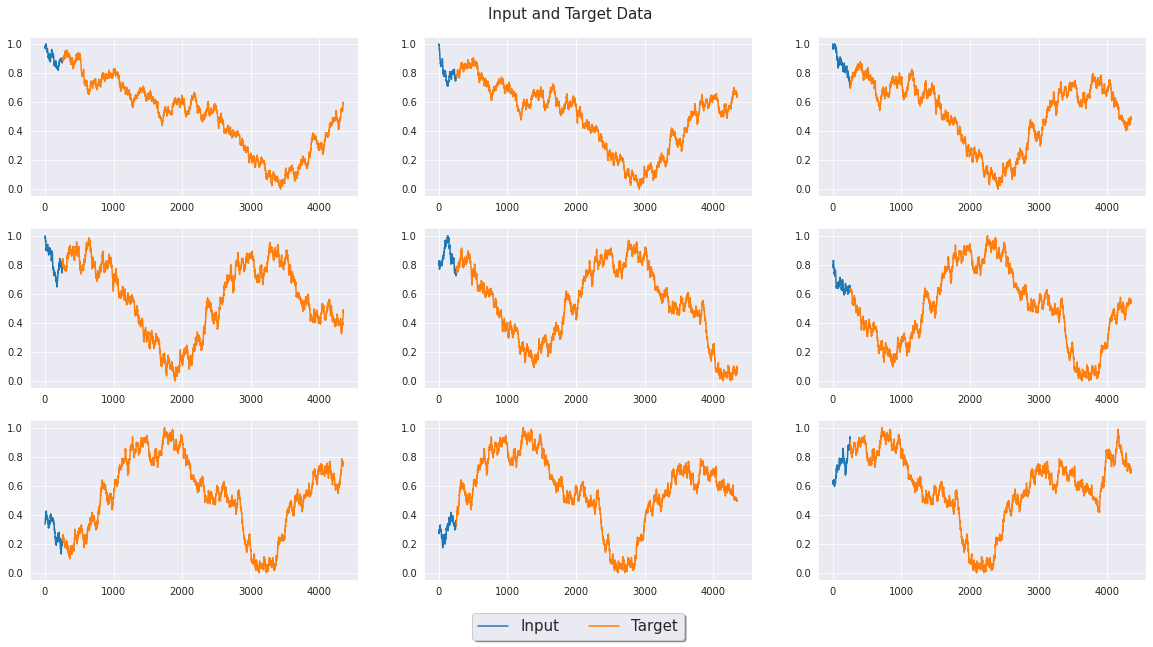

In [41]:
plt.figure(figsize=(20,10))
plt.suptitle('Input and Target Data',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
for k in range(9):
  plt.subplot(3,3,k+1)
  plot_test(trainX[k],trainY[k])
plt.legend(loc='lower center', bbox_to_anchor=(-0.73, -0.42),
           ncol=4, fancybox=True, shadow=True,prop={'size': 15}) 
plt.show()

In [123]:
round((l.beta(torch.Tensor(trainX))[k].detach().numpy()[0] - l.beta(torch.Tensor(trainY))[k].detach().numpy()[0]),4)

0.0937

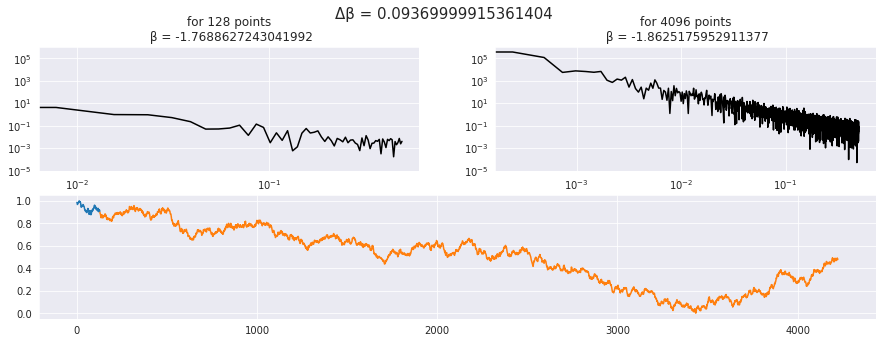

In [126]:
k = 0


plt.figure(figsize=(15,5))
plt.suptitle(f'Δβ = {round((l.beta(torch.Tensor(trainX))[k].detach().numpy()[0] - l.beta(torch.Tensor(trainY))[k].detach().numpy()[0]),4)}',  y=0.95, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
plt.subplot(2,2,1)
plot_psd(trainX[k])
plt.ylim(1e-5,1e6)
plt.title(f'for {len(trainX[k])} points\n β = {l.beta(torch.Tensor(trainX))[k].detach().numpy()[0]}')
plt.subplot(2,2,2)
plt.title(f'for {len(trainY[k])} points\n β = {l.beta(torch.Tensor(trainY))[k].detach().numpy()[0]}')
plot_psd(trainY[k])
plt.ylim(1e-5,1e6)
plt.subplot(2,2,(3,4))
plot_test(trainX[k],trainY[k])
#plt.text(1, 1, r'$\mathcal{A}\mathrm{sin}(2 \omega t)$')

# Data Analysis

In [130]:
def dataset_test(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  '''
  Create a data 1 sets for teste the spectra time series
  Here the data_set will be splited like in create_dataset but without test data
  All the data will be splited in two type of series.
  '''
  data_train_X, data_train_Y = [], []
  for i in range(0,len(dataset)-window_in-window_ou+1,strid):
    data_train_X.append(norm4(dataset[i:(i+window_in)]))
    data_train_Y.append(norm4(dataset[i + window_in:i + window_in + window_ou]))
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)

#Data Set 03 - TrainX and TrainY from a single Series

def dataset_test2(beta,n_series, len_trainX=10,len_trainY=10,isTensor=True):
  '''
  We create a time serie and split it in trainX and trainY
  '''
  data_train_X, data_train_Y = [], []
  for i in range(n_series):
    dataset = norm4(cn.powerlaw_psd_gaussian(beta, len_trainX+len_trainY))
    data_train_X.append(dataset[:len_trainX])
    data_train_Y.append(dataset[len_trainX:])
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)    

In [131]:
win_in = 128
win_ou = 2048*2
jump   = 512

#Data Set 01 - Recorted dataset
trainX_wn_01, trainY_wn_01 = dataset_test(wn,win_in,win_ou,jump,isTensor=True)
trainX_pn_01, trainY_pn_01 = dataset_test(pn,win_in,win_ou,jump,isTensor=True)
trainX_rn_01, trainY_rn_01 = dataset_test(rn,win_in,win_ou,jump,isTensor=True)

#Data Set 02 - Generated All Single Series

trainX_wn_02,trainX_pn_02,trainX_rn_02 = [],[],[]
trainY_wn_02,trainY_pn_02,trainY_rn_02 = [],[],[]
for i in range(len(trainX_wn_01)):
  trainX_wn_02.append(norm4(cn.powerlaw_psd_gaussian(0, win_in)))
  trainY_wn_02.append(norm4(cn.powerlaw_psd_gaussian(0, win_ou)))
  trainX_pn_02.append(norm4(cn.powerlaw_psd_gaussian(1, win_in)))
  trainY_pn_02.append(norm4(cn.powerlaw_psd_gaussian(1, win_ou)))
  trainX_rn_02.append(norm4(cn.powerlaw_psd_gaussian(2, win_in)))
  trainY_rn_02.append(norm4(cn.powerlaw_psd_gaussian(2, win_ou)))

trainX_wn_02, trainY_wn_02= torch.tensor(trainX_wn_02), torch.tensor(trainY_wn_02)
trainX_pn_02, trainY_pn_02= torch.tensor(trainX_pn_02), torch.tensor(trainY_pn_02)
trainX_rn_02, trainY_rn_02= torch.tensor(trainX_rn_02), torch.tensor(trainY_rn_02)

#Data Set 03 - TrainX and TrainY from a single Series
trainX_wn_03, trainY_wn_03 = dataset_test2(0,len(trainX_wn_01),win_in,win_ou)
trainX_pn_03, trainY_pn_03 = dataset_test2(1,len(trainX_wn_01),win_in,win_ou)
trainX_rn_03, trainY_rn_03 = dataset_test2(2,len(trainX_wn_01),win_in,win_ou)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


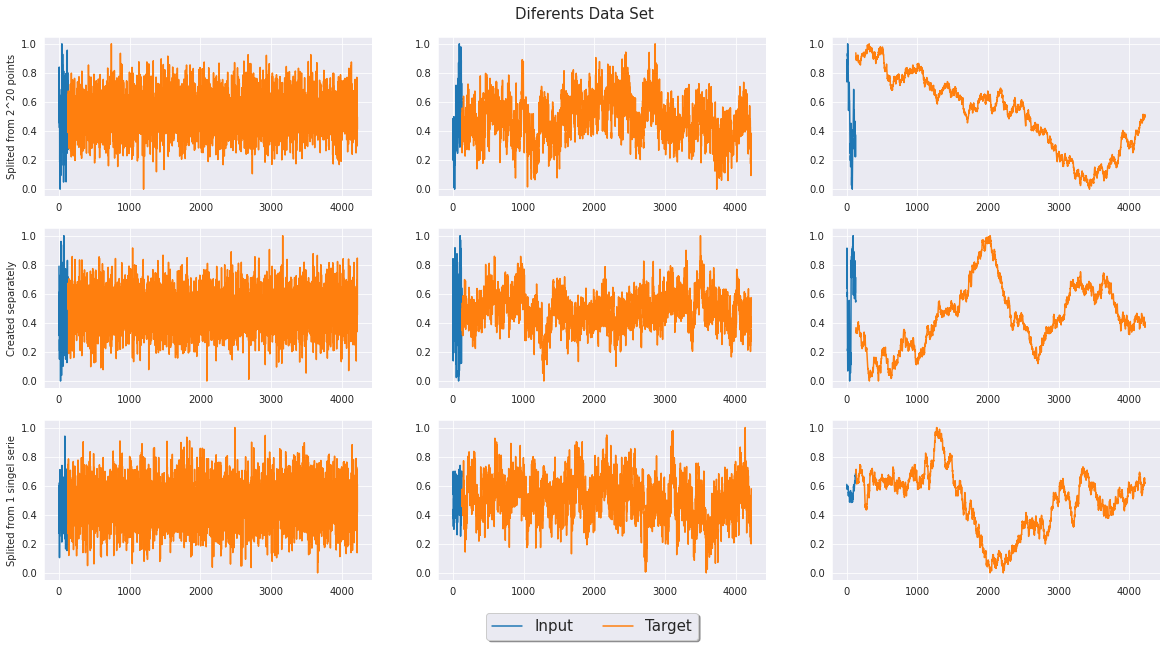

In [132]:
plt.figure(figsize=(20,10))
plt.suptitle('Diferents Data Set',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
k=0
plt.subplot(3,3,1)
plt.ylabel(f'Splited from 2^{int(np.log2(len(wn)))} points')
#plt.title('White Noise')
plot_test(trainX_wn_01[k],trainY_wn_01[k])
plt.subplot(3,3,2)
#plt.title('Pink Noise')
plot_test(trainX_pn_01[k],trainY_pn_01[k])
plt.subplot(3,3,3)
#plt.title('Red Noise')
plot_test(trainX_rn_01[k],trainY_rn_01[k])

plt.subplot(3,3,4)
plt.ylabel(f'Created separately')
plot_test(trainX_wn_02[k],trainY_wn_02[k])
plt.subplot(3,3,5)
plot_test(trainX_pn_02[k],trainY_pn_02[k])
plt.subplot(3,3,6)
plot_test(trainX_rn_02[k],trainY_rn_02[k])    

plt.subplot(3,3,7)
plt.ylabel(f'Splited from 1 singel serie')
plot_test(trainX_wn_03[k],trainY_wn_03[k])
plt.subplot(3,3,8)
plot_test(trainX_pn_03[k],trainY_pn_03[k])
plt.subplot(3,3,9)
plot_test(trainX_rn_03[k],trainY_rn_03[k])

plt.legend(loc='lower center', bbox_to_anchor=(-0.73, -0.42),
           ncol=4, fancybox=True, shadow=True,prop={'size': 15}) 
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

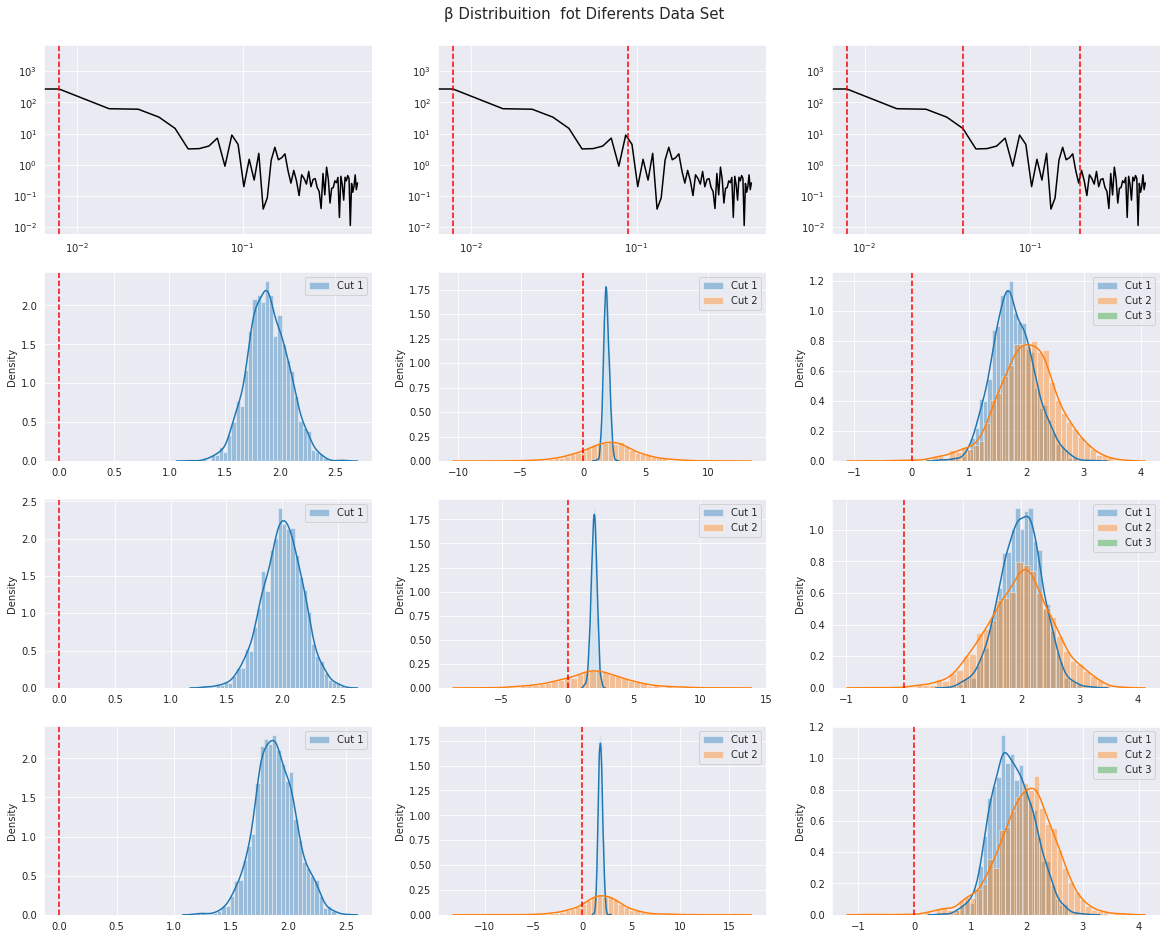

In [133]:
#l = DBeta(n_cut)

bet_index = 2
n_cut = 3
n_rowns = 4
#vets = [trainX_wn_01,trainX_wn_02,trainX_wn_03]
#vets = [trainX_pn_01,trainX_pn_02,trainX_pn_03]
vets = [trainX_rn_01,trainX_rn_02,trainX_rn_03]


def plot_ncut_beta(bet = 0,n_cut = 4,vet = trainX_wn_01,n_rowns = 1,c_colum = 1,possi1  = 1,title=None): 
  plt.subplot(n_rowns,c_colum,possi1)
  for i in range(0,n_cut): 
    l = DBeta(n_cut)#(i+1)#??????????  
    sns.distplot(-l.beta(vet)[:,i],label=f'Cut {i+1}')
  plt.axvline(bet_index,color = 'r', linestyle='--')
  #plt.title(title)
  plt.legend()

def plot_cuted_psd(bet = 0,n_cut = 4,vet = trainX_wn_01,n_rowns = 1,c_colum = 1,possi2  = 1,title=None):
  plt.subplot(n_rowns,c_colum,possi2)
  plot_psd(vet[0])
  for i in range(n_cut):  
    plt.axvline(x=(len(vet[0])**(-(i+1)/n_cut)),color='r',ls='--')


plt.figure(figsize=(20,16))
plt.suptitle('β Distribuition  fot Diferents Data Set',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
for i in range(1,n_cut+1):
  plot_cuted_psd(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi2  = i        ,title=f'{1}º cut')
  plot_ncut_beta(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi1  = (n_cut+i),title=f'{i}º cut')
  plot_ncut_beta(bet = bet_index,n_cut =i,vet = vets[1], n_rowns = n_rowns,c_colum = n_cut,possi1  = (2*n_cut+i),title=f'{i}º cut')
  plot_ncut_beta(bet = bet_index,n_cut =i,vet = vets[2], n_rowns = n_rowns,c_colum = n_cut,possi1  = (3*n_cut+i),title=f'{i}º cut')

In [ ]:
print('kurtosis',kurtosis(torch.tensor([wn2])))
print('mean',torch.mean(torch.tensor([wn2])))
print('skew',skew(torch.tensor([wn2])))
print('std',torch.std(torch.tensor([wn2])))

kurtosis tensor([0.0041], dtype=torch.float64)
mean tensor(0.4814, dtype=torch.float64)
skew tensor([0.0011], dtype=torch.float64)
std tensor(0.1008, dtype=torch.float64)


## Plot on Violin


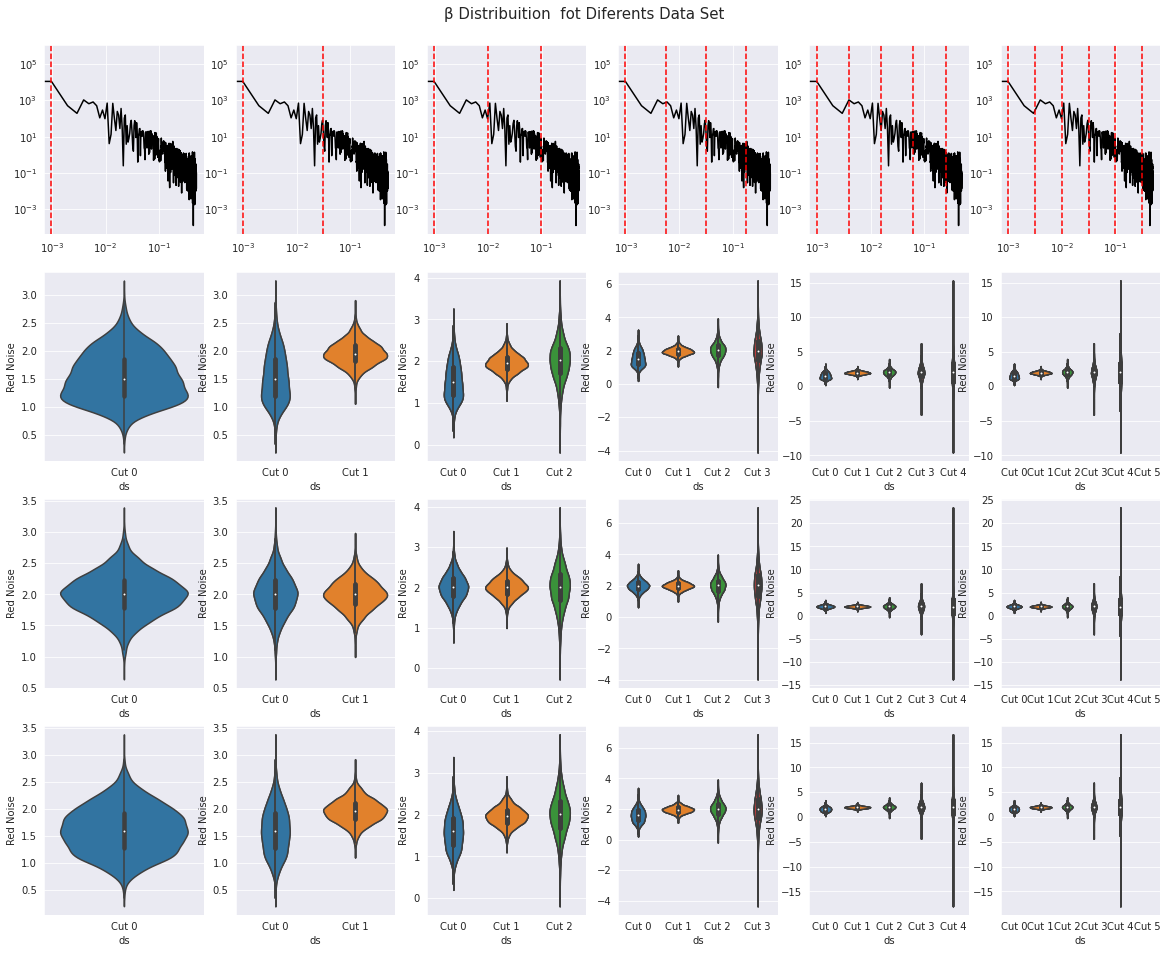

In [ ]:
#Ploting Paramenters

#df = pd.DataFrame({'White Noise':wn_Y,'Pink Noise':pn_Y,'Red Noise':rn_Y})
n_cut = 6
l = DBeta(n_cut)
data = vets[0]
bet_index = 2
n_rowns = 4
vets = [trainX_rn_01,trainX_rn_02,trainX_rn_03]
data_name = "Red Noise"

def beta_df(data,data_name,n_cut):
  cuted_beta = [] #empty vector
  for i in range(n_cut): cuted_beta.append(-l.beta(data)[:,i]) #Alocating betas from the functions
  sum = torch.cat(cuted_beta).detach().numpy() #concatoneting all data in ine single numpy vector
  _df = pd.DataFrame() #Creating a dataframe
  _df.insert(0,data_name,sum) #Inserting sum on data frame
  _ds = [] #creating a vector for cut type
  for i in range(len(cuted_beta)): 
    for j in range(cuted_beta[i].size(0)): _ds.append(f'Cut {i}')
  _df.insert(1,'ds',_ds)
  return _df


def plot_ncut_beta_violin(bet = 0,n_cut = 4,vet = trainX_wn_01,n_rowns = 1,c_colum = 1,possi1  = 1,title=None): 
  plt.subplot(n_rowns,c_colum,possi1)
  for i in range(0,n_cut): 
    l = DBeta(n_cut)#(i+1)#??????????  
    sns.violinplot(x='ds',y=data_name,data=beta_df(vet,data_name,n_cut))
  #plt.title(title)
  #plt.legend()

def plot_cuted_psd(bet = 0,n_cut = 4,vet = trainX_wn_01,n_rowns = 1,c_colum = 1,possi2  = 1,title=None):
  plt.subplot(n_rowns,c_colum,possi2)
  plot_psd(vet[0])
  for i in range(n_cut):  
    plt.axvline(x=(len(vet[0])**(-(i+1)/n_cut)),color='r',ls='--')

plt.figure(figsize=(20,16))
plt.suptitle('β Distribuition  fot Diferents Data Set',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
for i in range(1,n_cut+1):
  plot_cuted_psd(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi2  = i        ,title=f'{1}º cut')
  plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi1  = (n_cut+i),title=f'{i}º cut')
  plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[1], n_rowns = n_rowns,c_colum = n_cut,possi1  = (2*n_cut+i),title=f'{i}º cut')
  plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[2], n_rowns = n_rowns,c_colum = n_cut,possi1  = (3*n_cut+i),title=f'{i}º cut')

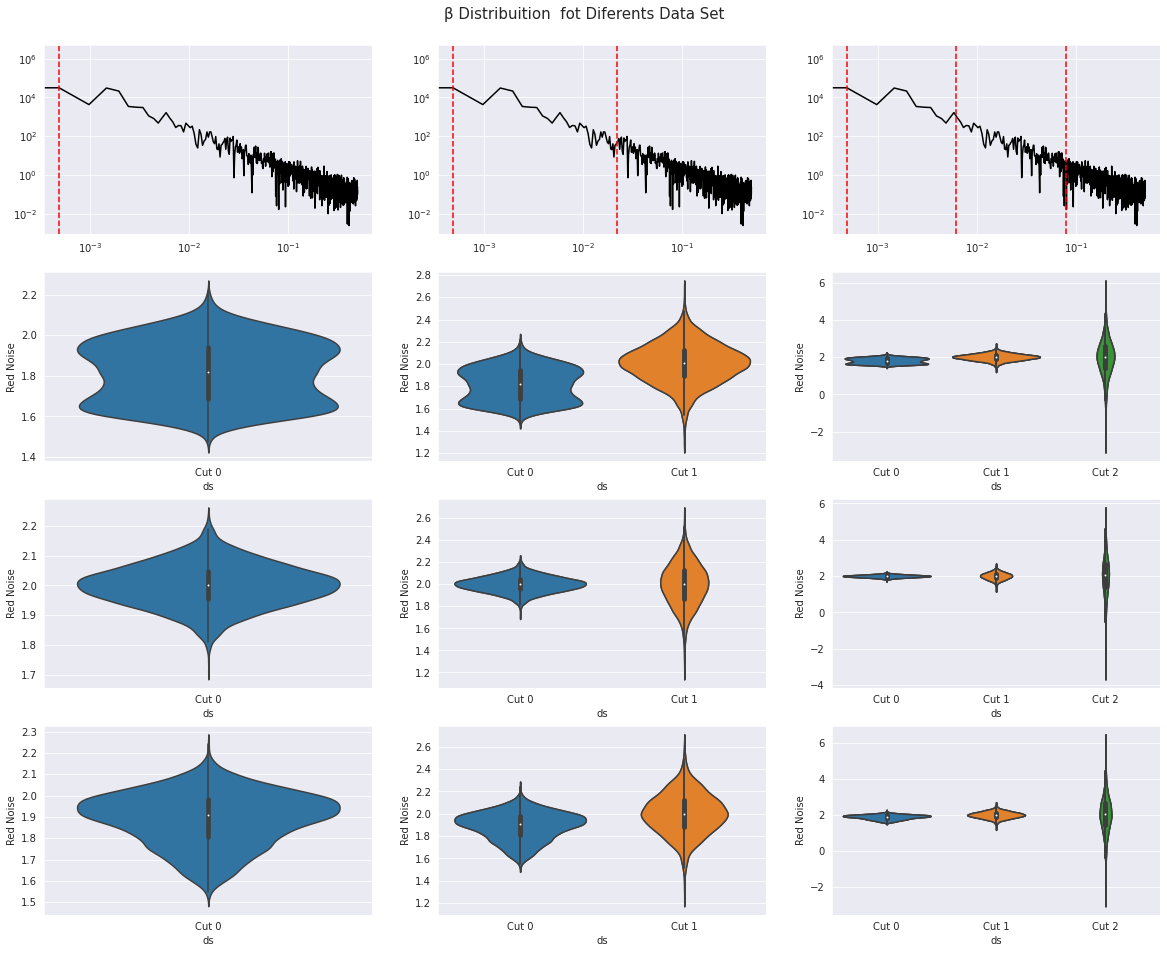

In [ ]:
#Ploting Paramenters

#df = pd.DataFrame({'White Noise':wn_Y,'Pink Noise':pn_Y,'Red Noise':rn_Y})
n_cut = 3
l = DBeta(n_cut)
data = vets[0]
bet_index = 2
n_rowns = 4
vets = [trainY_rn_01,trainY_rn_02,trainY_rn_03]
data_name = "Red Noise"

def beta_df(data,data_name,n_cut):
  cuted_beta = [] #empty vector
  for i in range(n_cut): cuted_beta.append(-l.beta(data)[:,i]) #Alocating betas from the functions
  sum = torch.cat(cuted_beta).detach().numpy() #concatoneting all data in ine single numpy vector
  _df = pd.DataFrame() #Creating a dataframe
  _df.insert(0,data_name,sum) #Inserting sum on data frame
  _ds = [] #creating a vector for cut type
  for i in range(len(cuted_beta)): 
    for j in range(cuted_beta[i].size(0)): _ds.append(f'Cut {i}')
  _df.insert(1,'ds',_ds)
  return _df


def plot_ncut_beta_violin(bet = 0,n_cut = 4,vet = trainY_wn_01,n_rowns = 1,c_colum = 1,possi1  = 1,title=None): 
  plt.subplot(n_rowns,c_colum,possi1)
  for i in range(0,n_cut): 
    l = DBeta(n_cut)#(i+1)#??????????  
    sns.violinplot(x='ds',y=data_name,data=beta_df(vet,data_name,n_cut))
  #plt.title(title)
  #plt.legend()

def plot_cuted_psd(bet = 0,n_cut = 4,vet = trainX_wn_01,n_rowns = 1,c_colum = 1,possi2  = 1,title=None):
  plt.subplot(n_rowns,c_colum,possi2)
  plot_psd(vet[0])
  for i in range(n_cut):  
    plt.axvline(x=(len(vet[0])**(-(i+1)/n_cut)),color='r',ls='--')

plt.figure(figsize=(20,16))
plt.suptitle('β Distribuition  fot Diferents Data Set',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
for i in range(1,n_cut+1):
  plot_cuted_psd(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi2  = i        ,title=f'{1}º cut')
  plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi1  = (n_cut+i),title=f'{i}º cut')
  plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[1], n_rowns = n_rowns,c_colum = n_cut,possi1  = (2*n_cut+i),title=f'{i}º cut')
  plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[2], n_rowns = n_rowns,c_colum = n_cut,possi1  = (3*n_cut+i),title=f'{i}º cut')

# Models

A ideia dessa rede é evitar a dissonância informacional. A rede guarda internamente a memória de curto prazo, ao informar novamente a rede sobre o estado de curto prazo, poderemos estar reintroduzindo informação que já foi filtrada/descartada. Esta reintrodução de dado espúrio estamos chamando de dissonância informacional. 

## Training Loop

In [134]:
def training_loop(n_epochs, model, optimiser, loss_fn,  train_input, train_target, test_input, test_target,future):
    loss_history = [] #Vector for the Loss Plot
    train_input_clone = torch.clone(train_input)
    train_target_clone = torch.clone(train_target)
    test_input_clone = torch.clone(test_input)
    test_target_clone = torch.clone(test_target)
    for i in range(n_epochs):
        shuffle = torch.randperm(train_input_clone.size(0)) #Embaralhando a orgem das séries
        train_input_clone = train_input_clone[shuffle,:]
        train_target_clone = train_target_clone[shuffle,:]
        test_input_clone = test_input_clone[shuffle,:]
        test_target_clone = test_target_clone[shuffle,:]
        
        def closure():
            optimiser.zero_grad()
            out = model(train_input_clone,train_target_clone.size(1)-train_input_clone.size(1))
            loss = loss_fn(out, train_target_clone)
            loss.backward()
            return loss
        optimiser.step(closure)
        with torch.no_grad():
            pred2 = model(test_target_clone,future_preds=future)
            y2 = pred2.detach().numpy().copy()
            
        for j in range(0,len(y2)): y2[j] = norm4(y2[j])
        # draw figures
        plt.figure(figsize=(15,6))
        gs = GridSpec(1,2,width_ratios=[2,1])
        
        plt.subplot(gs[0,0])
        plt.title("Epoch "+str(i+1))
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        n = train_input.shape[1] # 999
        m = train_target.shape[1]
        def draw(x_true,y_true, y_pred2, colour):
            plt.plot(np.arange(32,n), x_true[32:n], color='C0', linewidth=1.0,label='Input')            
            plt.plot(np.arange(32+32+len(x_true[32:n]),32+32+len(x_true[32:n])+len(y_true[32:])), y_true[32:],color='C1',label='Output')
            plt.plot(np.arange(n,n+len(y_pred2[32:m])), y_pred2[32:m], color = 'brown', linewidth=1.0,label='Expected')
            plt.plot(np.arange(n+m,n+m+len(y_pred2[m:])), y_pred2[m:], color = 'green', linewidth=1.0,label='Future')
            plt.axvline(n+m,ls='--')
            plt.legend()
        
        draw(test_input[0],test_target[0],y2[0], 'k')
        plt.subplot(gs[0,1])
        plot_psd(y2[0,32:m],'Expected','brown')
        plot_psd(y2[0,m:],'Future','green')
        plot_psd(test_target[0],'Output','C1')
        plt.xlabel("f (Frequency)")
        plt.ylabel("Energy (PSD)")
        plt.tight_layout()
        plt.legend()
        #plt.savefig("predict%d.png"%i, dpi=200)
        plt.show()
        plt.close()
        # print the loss
        out = model(train_input)
        loss_print = loss_fn(out, train_target)
        loss_history.append(loss_print)
        #for param in model.parameters():
        #  print(param.data)
        print("Epoch: {}, Loss: {}".format(i+1, loss_print))
    return loss_history

## MLP

In [150]:
class MLP(nn.Module):
    #def __init__(self, input_size, hidden_size, output_size):
    def __init__(self, input_size=1024, hidden_size=[32], activations=['sigmoid'],dropouts=[0.0], output_size=None):
        '''
        input_size - numero de entradas da rede (numero fixo)
        hidden_size - numero de neuronios na(s) camada(s) escondida (vetor)
        activations - lista da funcoes de ativacoes
        dropouts - lista de dropouts em cada camada
        output_size - numero de saidas da rede (por padrão eh igual a entrada) (numero fixo)
        '''
        super(MLP, self).__init__()

        if output_size==None:
          self.output_size = input_size
        else:
          self.output_size = output_size
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.combLayer = []
        self.activations = []
        self.dropouts = []
        self.n_layers = len(hidden_size)
        
        for index, n in enumerate(hidden_size):
          if index == 0:
            self.combLayer.append(nn.Linear(input_size, n))
            self.activations.append(self.__createActivation(activations[index]))
            self.dropouts.append(nn.Dropout(dropouts[index]))
          else:
            self.combLayer.append(nn.Linear(hidden_size[index-1], n)) 
            self.activations.append(self.__createActivation(activations[index]))
            self.dropouts.append(nn.Dropout(dropouts[index]))
        if self.n_layers == 1:
          self.combLayer.append(nn.Linear(hidden_size[0], self.output_size))
        else:
          self.combLayer.append(nn.Linear(hidden_size[-1],  self.output_size))
        self.activations.append(self.__createActivation(activations[-1]))
        self.dropouts.append(nn.Dropout(dropouts[-1]))

        self.combLayer = nn.ModuleList(self.combLayer)
        self.activations = nn.ModuleList(self.activations)
        self.dropouts = nn.ModuleList(self.dropouts)

    def __createActivation(self,nome):
        if nome=='sigmoid':
          return nn.Sigmoid()
        elif nome=='relu':
          return nn.ReLU()
        elif nome=='tanh':
          return nn.Tanh()

    def __str__(self):
        output  = ""
        for i in range(self.n_layers+1):
          output += "======================\n"
          output += "Layer: "+str(i)+"\n"
          output += str(self.combLayer[i])+"\n"
          output += str(self.activations[i])+"\n"
          output += str(self.dropouts[i])+"\n"
        return output

    def forward(self, x, future_preds=0):
        x2 = torch.clone(x)
        output = []
        for i in range(self.n_layers+1):
          x2 = self.combLayer[i](x2)
          x2 = self.activations[i](x2)
          x2 = self.dropouts[i](x2)
        output.append(x2)
        stepSize = x2.size(1)
        n = 0
        xpast = torch.clone(x2)
        
        while n<future_preds:
          xnew = torch.clone(xpast) 
          for j in range(self.n_layers+1):
            xnew = self.combLayer[j](xnew)
            xnew = self.activations[j](xnew)
            xnew = self.dropouts[j](xnew)
          xpast = xnew
          output.append(xnew)
          n = n+xnew.size(1)
        output = torch.cat(output, dim=1)
        
        output = output[:,:x.size(1)+future_preds]
        return output

    def __call__(self, x, future_preds=0):
      return self.forward(x, future_preds)

print(MLP(hidden_size=[32,64,128],activations=['sigmoid','tanh','relu','sigmoid'],dropouts=[0.0,0.5,0.9,0.666]))
#print(MLP(hidden_size=[32,64,128],activations=['sigmoid','tanh','relu'],dropouts=[0.0]))

Layer: 0
Linear(in_features=1024, out_features=32, bias=True)
Sigmoid()
Dropout(p=0.0, inplace=False)
Layer: 1
Linear(in_features=32, out_features=64, bias=True)
Tanh()
Dropout(p=0.5, inplace=False)
Layer: 2
Linear(in_features=64, out_features=128, bias=True)
ReLU()
Dropout(p=0.9, inplace=False)
Layer: 3
Linear(in_features=128, out_features=1024, bias=True)
Sigmoid()
Dropout(p=0.666, inplace=False)



In [153]:
l = DBeta(2)

#model = MLP(hidden_size=[1024,1024,1024],activations=['sigmoid','sigmoid','sigmoid','sigmoid'],dropouts=[0.0,0.0,0.00,0.0])
model = LSTM_GNI()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)
history = training_loop(30, model, optimiser,l, trainX.float(), trainY.float(), trainX_test.float(), trainY_test.float(),future=1024)

TypeError: ignored

## RNN

In [141]:
class RNN_GNI(nn.Module):
    def __init__(self, hidden_layers=32,isGNI=True):
        super(RNN_GNI, self).__init__()
        self.hidden_layers = hidden_layers
        self.isGNI = isGNI
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.RNNCell( 1, self.hidden_layers)
        self.lstm2 = nn.RNNCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        self.act = nn.Sigmoid() 
        
    def forward(self, y, future_preds=0):
        outputs, batch_size = [], y.size(0)
        #self.white_noise = torch.empty()
        h_t = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        #c_t = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        #c_t2 = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)

        for time_step in y.split(1, dim=1):
            # N, 1
            if self.isGNI: 
              input = torch.rand(batch_size,1)
            else:
              input = time_step
            h_t = self.lstm1(input, h_t) # initial hidden and cell states
            h_t2 = self.lstm2(h_t, h_t2) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            output = self.act(output)
            outputs.append(output)
            
        for i in range(future_preds):
            #this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            if self.isGNI: 
              input = torch.rand(batch_size,1)
            else:
              input = output
            h_t= self.lstm1(input, h_t)
            h_t2 = self.lstm2(h_t, h_t2)
            output = self.linear(h_t2)
            output = self.act(output)
            outputs.append(output)      
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs
    def __call__(self,y, future_preds=0):
      return self.forward(y, future_preds)


## LSTM

In [139]:
class LSTM_GNI(nn.Module):
    def __init__(self, hidden_layers=32,isGNI=True):
        super(LSTM_GNI, self).__init__()
        self.hidden_layers = hidden_layers
        self.isGNI = isGNI
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell( 1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        self.act = nn.Sigmoid() 
        
    def forward(self, y, future_preds=0):
        outputs, batch_size = [], y.size(0)
        #self.white_noise = torch.empty()
        h_t = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)

        for time_step in y.split(1, dim=1):
            # N, 1
            if self.isGNI: 
              input = torch.rand(batch_size,1)
            else:
              input = time_step
            h_t, c_t = self.lstm1(input, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            output = self.act(output)
            outputs.append(output)
            
        for i in range(future_preds):
            #this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            if self.isGNI: 
              input = torch.rand(batch_size,1)
            else:
              input = output
            h_t, c_t = self.lstm1(input, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            output = self.act(output)
            outputs.append(output)      
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs
    def __call__(self,y, future_preds=0):
      return self.forward(y, future_preds)


## GRU

In [140]:
class GRU_GNI(nn.Module):
    def __init__(self, hidden_layers=32,isGNI=True):
        super(GRU_GNI, self).__init__()
        self.hidden_layers = hidden_layers
        self.isGNI = isGNI
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.GRUCell( 1, self.hidden_layers)
        self.lstm2 = nn.GRUCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        self.act = nn.Sigmoid() 
        
    def forward(self, y, future_preds=0):
        outputs, batch_size = [], y.size(0)
        #self.white_noise = torch.empty()
        h_t = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        #c_t = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        #c_t2 = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)

        for time_step in y.split(1, dim=1):
            # N, 1
            if self.isGNI: 
              input = torch.rand(batch_size,1)
            else:
              input = time_step
            h_t = self.lstm1(input, h_t) # initial hidden and cell states
            h_t2 = self.lstm2(h_t, h_t2) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            output = self.act(output)
            outputs.append(output)
            
        for i in range(future_preds):
            #this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            if self.isGNI: 
              input = torch.rand(batch_size,1)
            else:
              input = output
            h_t= self.lstm1(input, h_t)
            h_t2 = self.lstm2(h_t, h_t2)
            output = self.linear(h_t2)
            output = self.act(output)
            outputs.append(output)      
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs
    def __call__(self,y, future_preds=0):
      return self.forward(y, future_preds)


## CNN

In [ ]:


#Create a CNN using pytorch, entering trainX and predicting trainY

class CNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.conv1 = nn.Conv1d(self.input_size, self.hidden_size, 3)
        self.conv2 = nn.Conv1d(self.hidden_size, self.hidden_size, 3)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.fc(x)
        return x


def train_CNN(trainX,trainY,trainX_test,trainY_test):
    input_size = trainX.shape[1]
    hidden_size = 256
    output_size = trainY.shape[1]
    model = CNN(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 100
    train_losses = []
    test_losses = []
    for i in range(epochs):
        y_pred = model(trainX.float())
        loss = criterion(y_pred, trainY.float())
        train_losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_test_pred = model(trainX_test.float())
            test_loss = criterion(y_test_pred, trainY_test.float())
            test_losses.append(test_loss)
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    return model

# Fit the Model

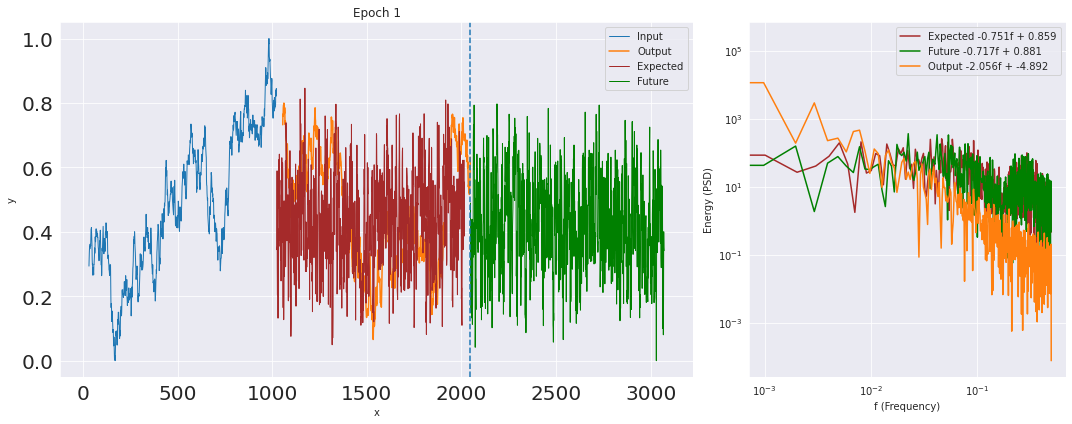

Epoch: 1, Loss: 0.10874021053314209


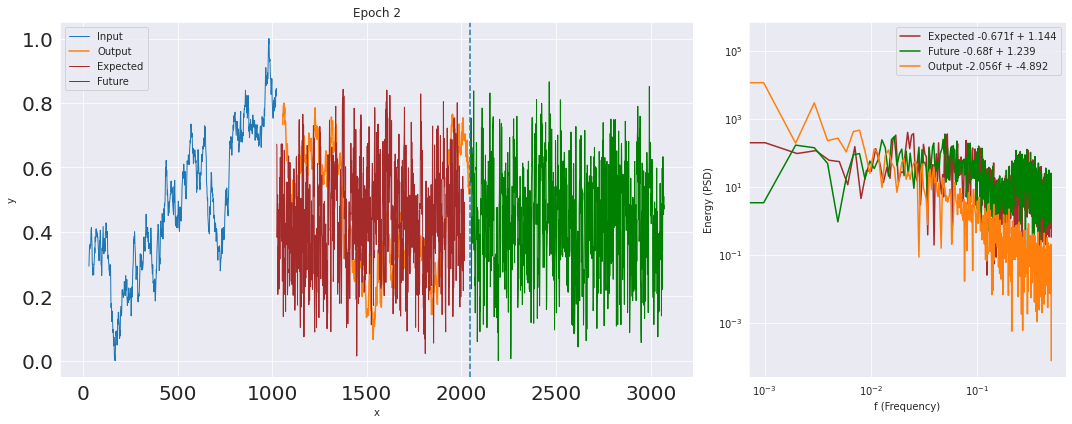

Epoch: 2, Loss: 0.11654504388570786


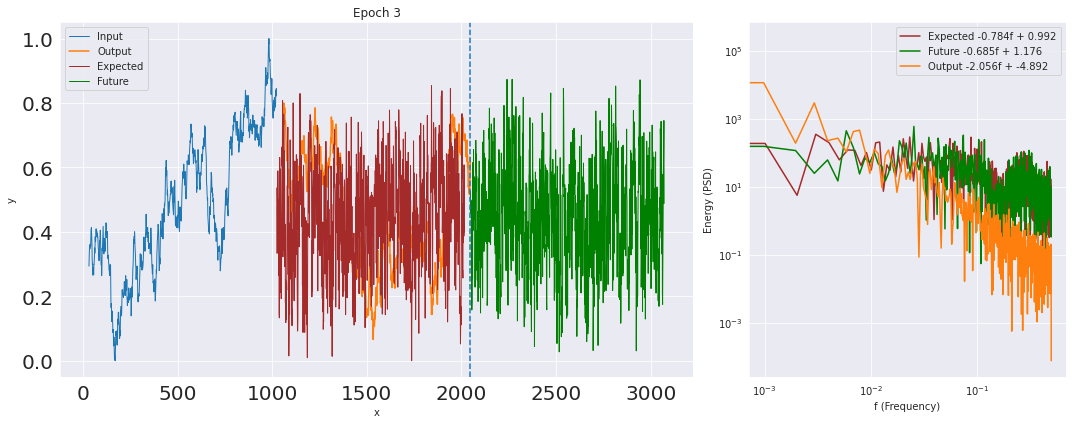

Epoch: 3, Loss: 0.09948188811540604


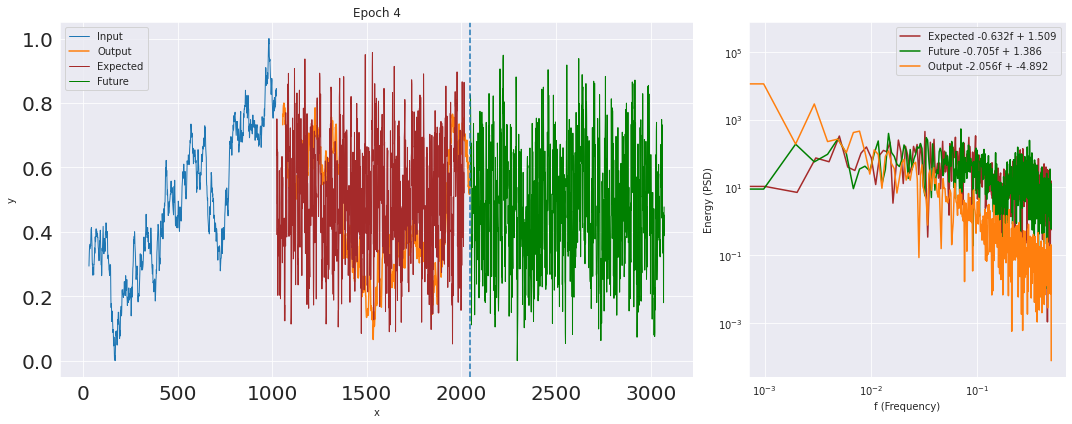

Epoch: 4, Loss: 0.09998226165771484


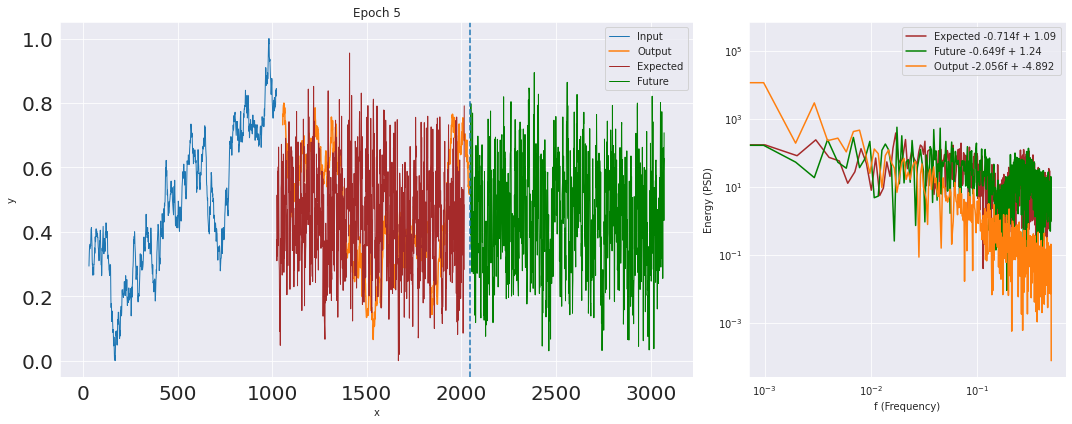

Epoch: 5, Loss: 0.10347840934991837


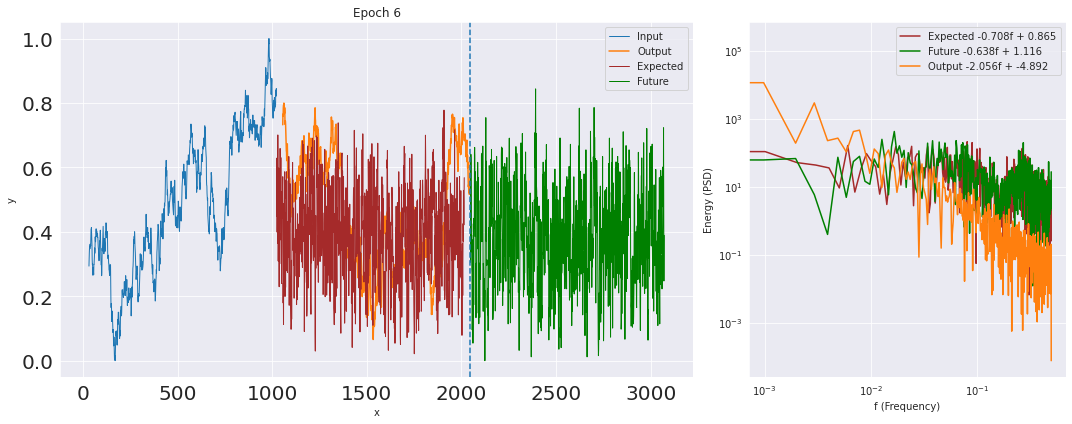

Epoch: 6, Loss: 0.10439340025186539


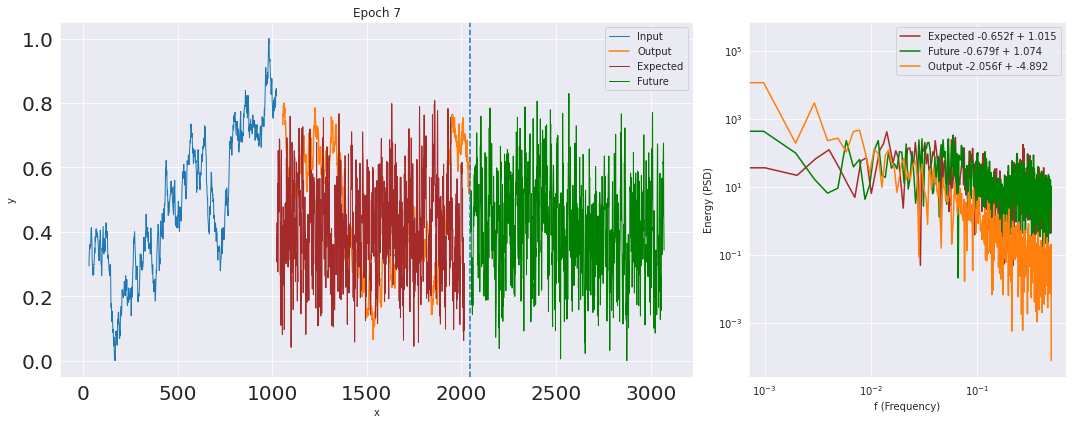

Epoch: 7, Loss: 0.08943700045347214


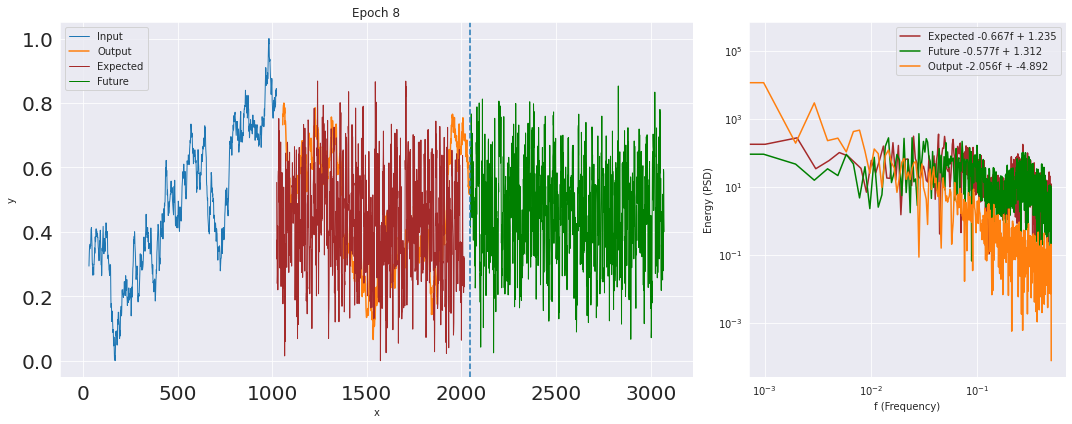

Epoch: 8, Loss: 0.09369143843650818


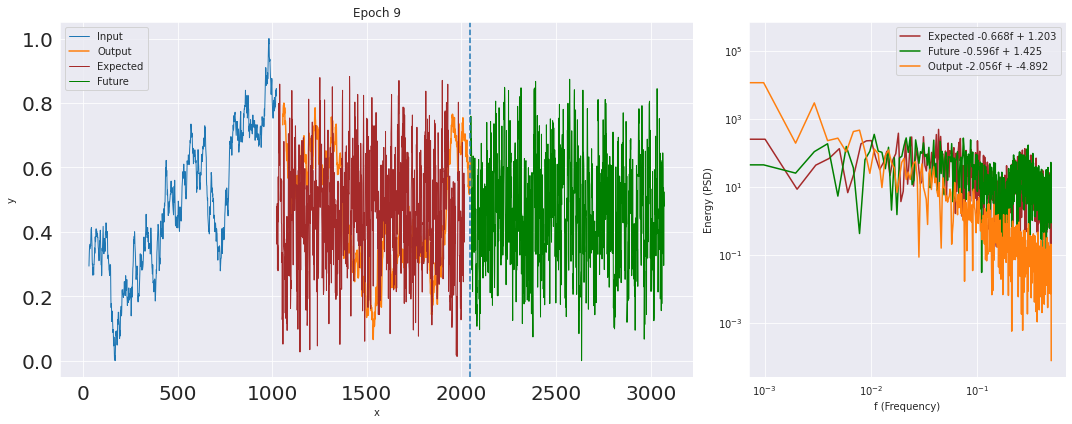

Epoch: 9, Loss: 0.10952047258615494


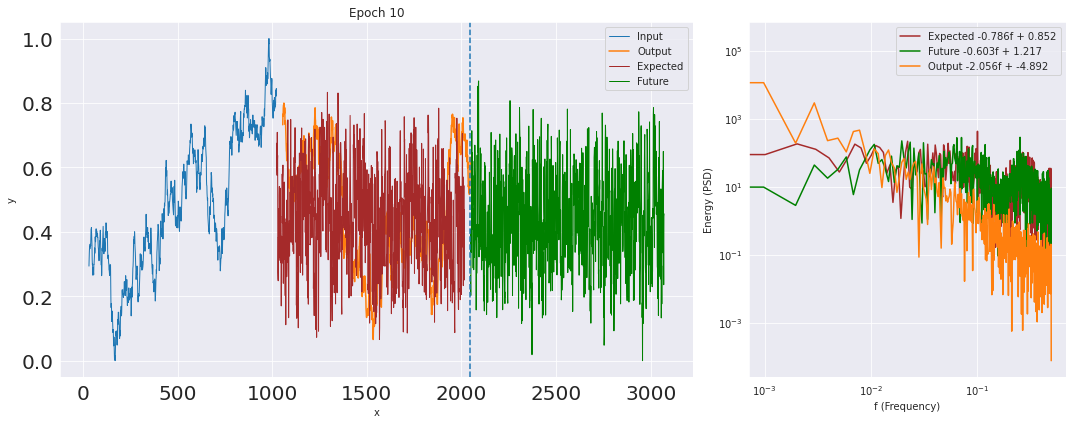

Epoch: 10, Loss: 0.1076728105545044


[tensor(0.1087, grad_fn=<MeanBackward0>),
 tensor(0.1165, grad_fn=<MeanBackward0>),
 tensor(0.0995, grad_fn=<MeanBackward0>),
 tensor(0.1000, grad_fn=<MeanBackward0>),
 tensor(0.1035, grad_fn=<MeanBackward0>),
 tensor(0.1044, grad_fn=<MeanBackward0>),
 tensor(0.0894, grad_fn=<MeanBackward0>),
 tensor(0.0937, grad_fn=<MeanBackward0>),
 tensor(0.1095, grad_fn=<MeanBackward0>),
 tensor(0.1077, grad_fn=<MeanBackward0>)]

In [157]:

#l = nn.MSELoss()
l = DBeta(3,high_freq_cut=1)

model = RNN_GNI()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)
training_loop(10, model, optimiser,l, trainX.float(), trainY.float(), trainX_test.float(), trainY_test.float(),future=len(trainY[0]))

Refazendo o plot da função de treino, pois a do exemplo é muito ruim. Excluimos os 32 iniciais devido a arquitetura da rede, este é o tempo necessário para preencher a memória da primeira camada. 

# Referencias 
[Copyright 2019, Rafael Ballester-Ripoll Revision 8c81a1cb.](https://tntorch.readthedocs.io/en/latest/_modules/metrics.html)

https://blog.paperspace.com/pytorch-loss-functions/

[LSTM and LSTMCell ？ - PyTorch Forums](https://discuss.pytorch.org/t/lstm-and-lstmcell/7488/5)